# 7. Calibration of single-ended measurement

A single-ended DTS measurement setup is a setup where the measurements are taken from one ending of the fiber, e.g., only one ending is connected to the DTS device. Opposed to double-ended setups, where measurements are taken from both endings of the fiber, the calibration of single-ended setups require the additional assumption that the losses (differential attenuation) is constant along the fiber. E.g., a sharp bend result additional losses and causes a false jump in the temperature. The estimation of the measurement uncertainty also assumes constant losses.

A single-ended calibration is performed where the unknown parameters are estimated using fiber sections that have a reference temperature. The parameters are estimated with a weighted least squares optimization using Stokes and anti-Stokes measurements from all timesteps. Thus Stokes and anti-Stokes measurements with a large signal to noise ratio contribute more towards estimating the optimal parameter set, but an estimate of the noise variance is required.

Single-ended calibration requires a few steps:
1. Read the raw data files loaded from your DTS machine
2. Define the reference sections: fiber sections that have a known temperature.
3. Estimate the variance of the noise in the Stokes and anti-Stokes measurements
4. Perform the parameter search and compute the temperature along the entire fiber.
5. Plot the temperature and uncertainty of the estimated temperature

Please have a look at [1] for more information.

[1]: des Tombe, B., Schilperoort, B., & Bakker, M. (2020). Estimation of Temperature and Associated Uncertainty from Fiber-Optic Raman-Spectrum Distributed Temperature Sensing. Sensors, 20(8), 2235. https://doi.org/10.3390/s20082235

In [1]:
import os

from dtscalibration import read_silixa_files
import matplotlib.pyplot as plt

%matplotlib inline

# Read the raw data files loaded from your DTS machine
Use `read_silixa_files` for reading files from a Silixa device. The following functions are available for reading files from other devices: `read_sensortran_files`, `read_apsensing_files`, and `read_sensornet_files`. See Notebook 1.

Calibration is performed on sections that have a known

In [2]:
filepath = os.path.join('..', '..', 'tests', 'data', 'single_ended')
ds = read_silixa_files(
    directory=filepath,
    timezone_netcdf='UTC',
    file_ext='*.xml')

3 files were found, each representing a single timestep
4 recorded vars were found: LAF, ST, AST, TMP
Recorded at 1461 points along the cable
The measurement is single ended
Reading the data from disk


# Define the reference fiber sections that have a known temperature
As explained in Notebook 3. DTS devices come with temperature probes to measure the temperature of the water baths. These measurements are stored in the data that was loaded in the previous step and are loaded automatically. In the case you would like to use an external temperature sensor, have a look at notebook `09Import_timeseries` to append those measurements to the `ds` before continuing with the calibration. 

In [ ]:
ds = ds.sel(x=slice(-30, 101))  # dismiss parts of the fiber that are not interesting
ds.sections = {
            'probe1Temperature':    [slice(20, 25.5)],   # warm bath
            'probe2Temperature':    [slice(5.5, 15.5)],  # cold bath
            }

# Estimate the variance of the noise in the Stokes and anti-Stokes measurements
First calculate the variance of the noise in the measured Stokes and anti-Stokes signals. See Notebook 4 for more information.

The Stokes and anti-Stokes signals should follow a smooth decaying exponential. This function fits a decaying exponential to each reference section for each time step. The variance of the residuals between the measured Stokes and anti-Stokes signals and the fitted signals is used as an estimate of the variance in measured signals. This algorithm assumes that the temperature is the same for the entire section but may vary over time and differ per section.

In [18]:
st_var, resid = ds.variance_stokes_constant(st_label='st')
ast_var, _ = ds.variance_stokes_constant(st_label='ast')

The following plot can be used to check if there are no spatial or temporal correlated residuals. If you see horizontal or vertical lines that means that you overestimate the st_var. Common reasons are that the temperature of that section is not uniform, e.g. that the reference sections were defined falsely or that the temperature of the water baths were not uniform.

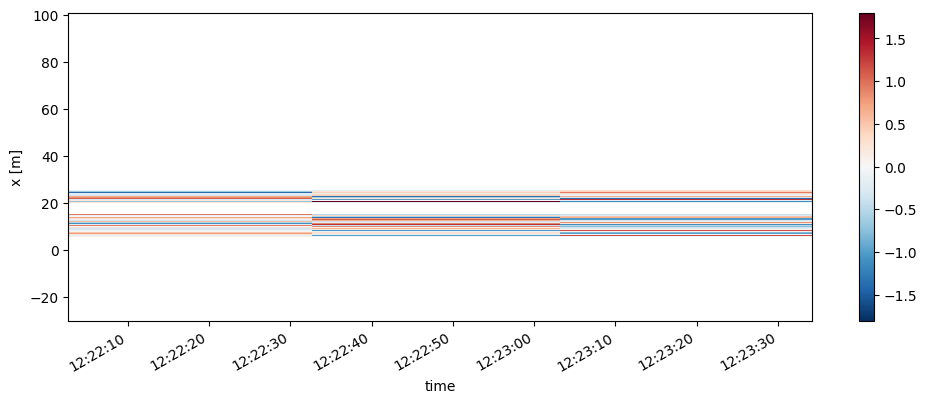

In [19]:
resid.plot(figsize=(12, 4));

# Perform calibration and compute the temperature
We calibrate the measurements and their uncertainty with a single method call. The temperature is stored by default as the `ds.tmpf` dataarray and the variance of its approximation as `ds.tmpf_var`.

In [20]:
ds.calibration_single_ended(
    st_var=st_var,
    ast_var=ast_var)

# Plot the temperature and uncertainty of the estimated temperature
First, the temperature for the entire fiber is plotted. Second, the temperature and its standard error are plotted for the first timestep.

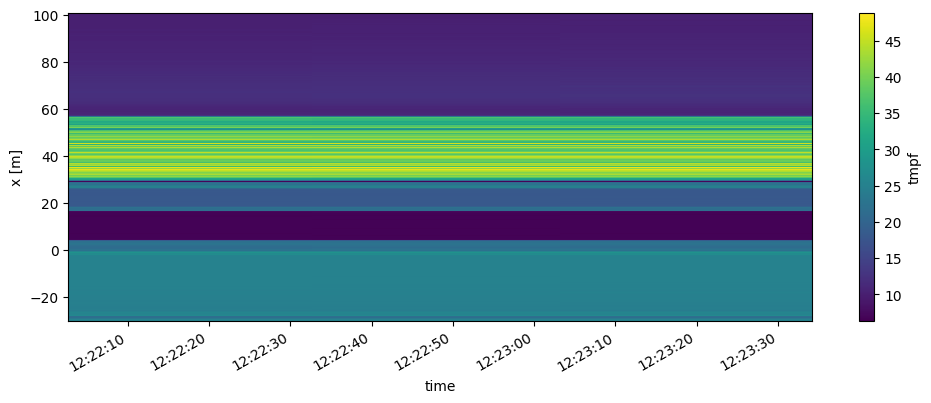

In [26]:
ds.tmpf.plot(figsize=(12, 4));

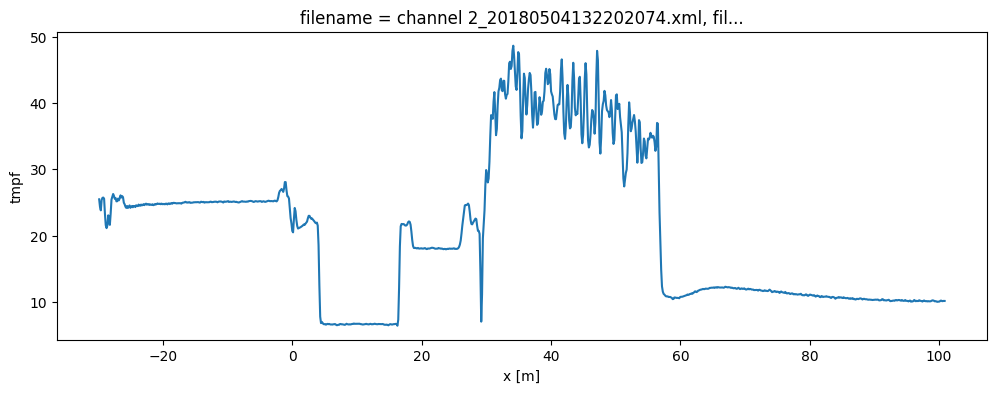

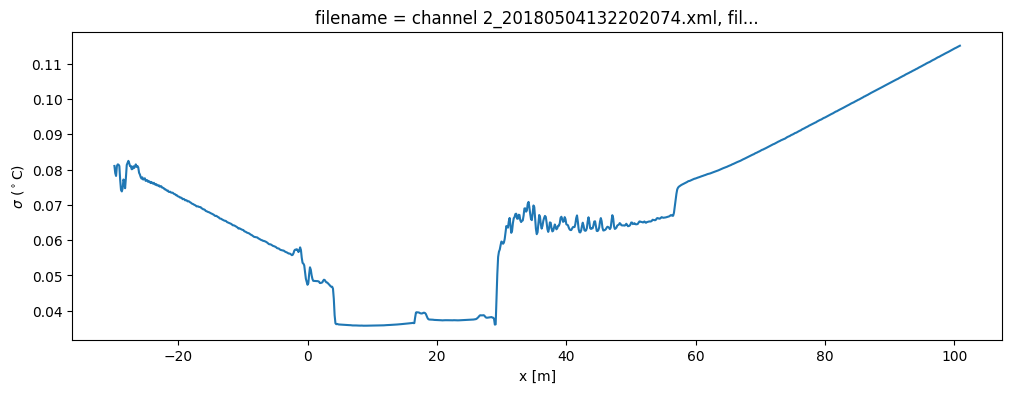

In [27]:
ds1 = ds.isel(time=0)
ds1.tmpf.plot(figsize=(12, 4));
(ds1.tmpf_var**0.5).plot(figsize=(12, 4));
plt.ylabel('$\sigma$ ($^\circ$C)');

The variance of the temperature measurement appears to be larger than what the manufacturer reports. This is already the case for the internal cable; it is not caused by a dirty connector/bad splice on our side. Maybe the length of the calibration section was not sufficient.

At 30 m the variance sharply increases. There are several possible explanations. E.g., large temperatures or decreased signal strength.

Lets have a look at the Stokes and anti-Stokes signal.

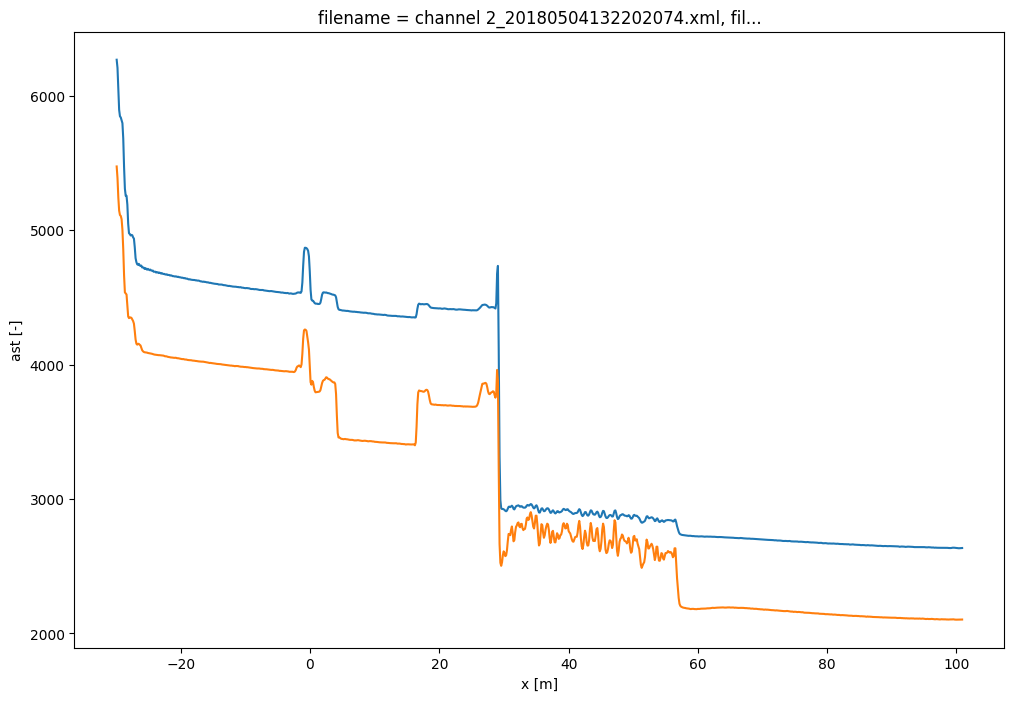

In [12]:
ds1.st.plot(figsize=(12, 8))
ds1.ast.plot();

Clearly there was a bad splice at 30 m that resulted in the sharp increase of measurement uncertainty for the cable section after the bad splice.

Note that the uncertainty of the temperature strongly varies along the fiber. Dive deeper in the uncertainty of the temperature estimate in another notebook

In [28]:
ds.conf_int_single_ended(
    st_var=st_var,
    ast_var=ast_var,
    conf_ints=[2.5, 97.5],
    mc_sample_size=500)

Lets compare our calibrated values with the device calibration

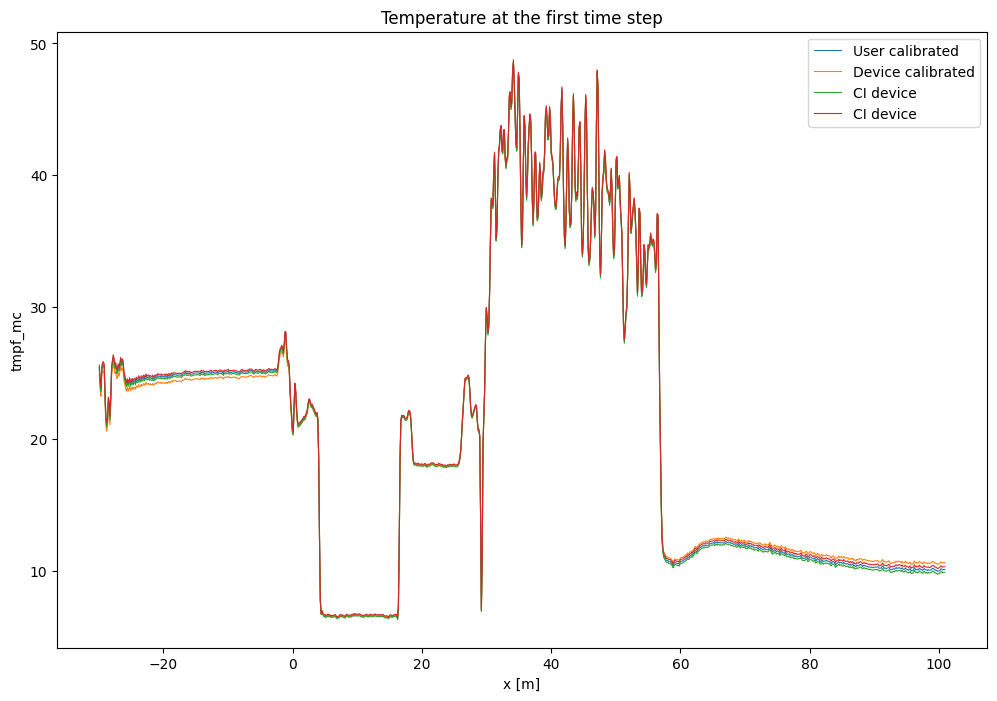

In [7]:
ds1 = ds.isel(time=0)  # take only the first timestep
ds1.tmpf.plot(linewidth=0.8, figsize=(12, 8), label='User calibrated')  # plot the temperature calibrated by us
ds1.tmp.plot(linewidth=0.8, label='Device calibrated')  # plot the temperature calibrated by the device
ds1.tmpf_mc.plot(linewidth=0.8, hue='CI', label='CI device')
plt.title('Temperature at the first time step')
plt.legend();

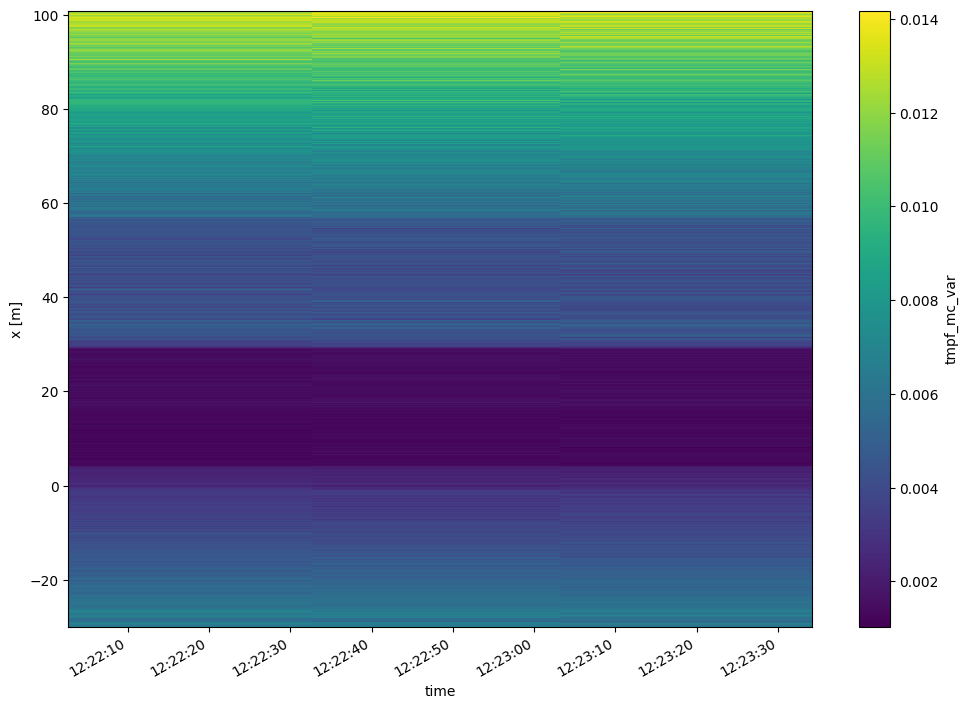

In [8]:
ds.tmpf_mc_var.plot(figsize=(12, 8));

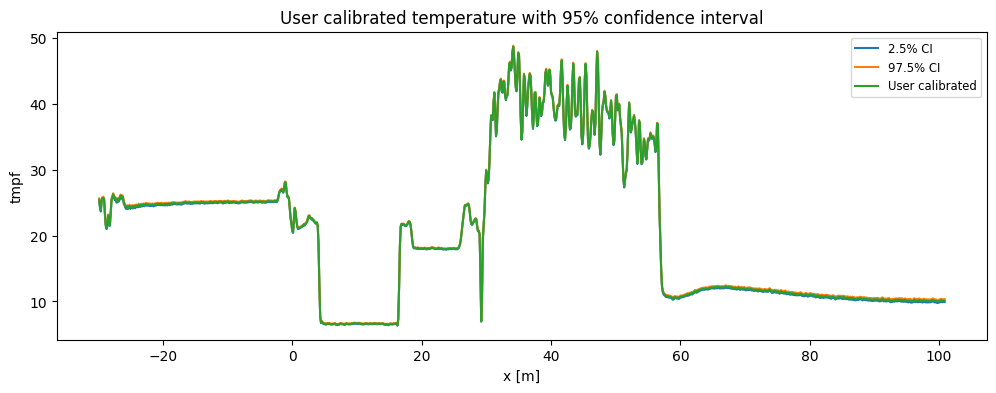

In [16]:
ds1.tmpf_mc.sel(CI=2.5).plot(label = '2.5% CI', figsize=(12, 4))
ds1.tmpf_mc.sel(CI=97.5).plot(label = '97.5% CI')
ds1.tmpf.plot(label='User calibrated')
plt.title('User calibrated temperature with 95% confidence interval')
plt.legend(fontsize='small');

We can tell from the graph above that the 95% confidence interval widens furtherdown the cable. Lets have a look at the calculated variance along the cable for a single timestep. According to the device manufacturer this should be around 0.0059 degC.

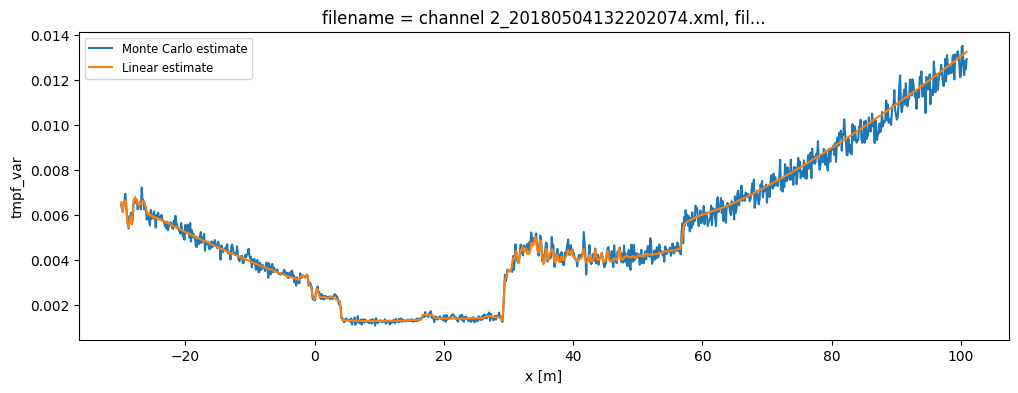

In [14]:
ds1.tmpf_mc_var.plot(figsize=(12, 4), label='Monte Carlo estimate');
ds1.tmpf_var.plot(label='Linear estimate');
plt.legend(fontsize='small');